In [75]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at

import astropy.cosmology as cosmo
import astropy.units as u
import h5py
import scipy.stats as st

In [76]:
seed = 0
np.random.seed(seed)

#####################################################################################################

data = np.loadtxt('/home/soumendrakishore.roy/Om_final/Results/z_DL_gpc_snr.dat', unpack=True)
mask = data[0]>0.2
z = data[0][mask]
DL = data[1][mask]
snr = data[2][mask]

#####################################################################################################

snr_cut = 0
mask = snr>snr_cut

z1 = z[mask]
DL1 = DL[mask]
snr1 = snr[mask]

#####################################################################################################

Nobs = 100

rng = np.random.default_rng(seed=seed)
ind = rng.choice(len(z1), size=Nobs, replace=False)

zo = z1[ind]
DLo = DL1[ind]
snro = snr1[ind]

sigma_DL = DLo/snro

#####################################################################################################

do = DLo # +sigma_DL*np.random.randn(Nobs) # in Gpc
sdo = sigma_DL

print(np.where(do<0)) # check do>0 always 


(array([], dtype=int64),)


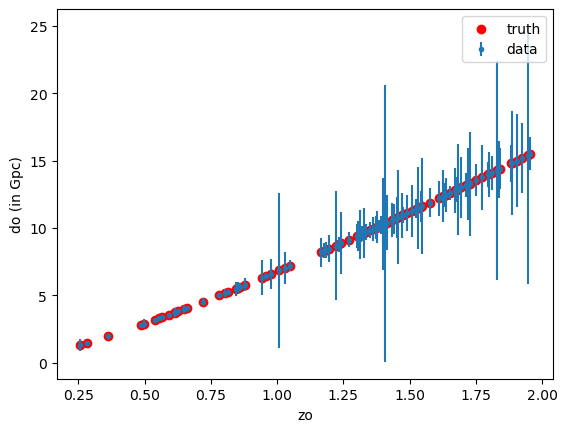

In [77]:
cp = cosmo.Planck18
plt.errorbar(zo, do, yerr=sdo, fmt='.', label='data')
plt.scatter(zo, cp.luminosity_distance(zo).to(u.Gpc).value, color='red', label='truth')
plt.xlabel('zo')
plt.ylabel('do (in Gpc)')
plt.legend()

In [78]:
Nbin = 5
zl = np.linspace(min(zo), max(zo), Nbin+1)
zb = np.zeros(Nbin)
for i in range(Nbin):
    zb[i] = (zl[i]+zl[i+1])/2
print("zb=", zb)

ind = np.argsort(zo)
zo2 = zo[ind]
do2 = do[ind]
sd2 = sdo[ind]

do1 = np.zeros((Nobs,Nbin))
sd1 = np.zeros((Nobs,Nbin))
for i in range(Nobs):
    do1[i].fill(do2[i])
    sd1[i].fill(sd2[i])
print(do1.shape, sd1.shape)

zb= [0.42502179 0.7653431  1.10566441 1.44598572 1.78630703]
(100, 5) (100, 5)


In [79]:
from numpy import exp, log
sou = np.array([[-23, -25, -50], [-21, -22, -23]])
sou1 = np.amin(sou, axis=1)[:, None]
print(np.sum(log(np.sum(exp(sou), axis=1))))
print(np.sum(np.log(np.sum(np.exp(sou-sou1),axis=1)))+np.sum(sou1.flatten()))

-43.46546602451099
-43.465466024510995


In [82]:
with pm.Model() as model:
    DL_test = cp.luminosity_distance(zb).to(u.Gpc).value
    #mu = pm.Normal('mu', mu=DL_test, sigma=np.ones((Nbin)), shape=Nbin)
    logl = pm.Uniform("logl", -1.0, np.log(10.0))
    logs2f = pm.Uniform("logs2f", -10.0, 10.0)
    l = at.exp(logl)
    s2f = at.exp(logs2f)
    f_cov = s2f*pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(DL_test), cov_func=f_cov)
    DLb = gp.prior("DLb", zb[:, None])
    
    prob = at.exp(pm.logp(pm.Normal.dist(do1, sd1), DLb))
    prob1 = at.sum(prob, axis=1)
    print(np.where(prob1.eval()==0))

(array([], dtype=int64),)


In [83]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logl, logs2f, DLb_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [84]:
DLb_fit = trace.posterior["DLb"][0]
DLb_med = np.median(DLb_fit, axis=0)
DLb_sd = np.std(DLb_fit, axis=0)

Text(0, 0.5, 'Luminosity Distance (in Gpc)')

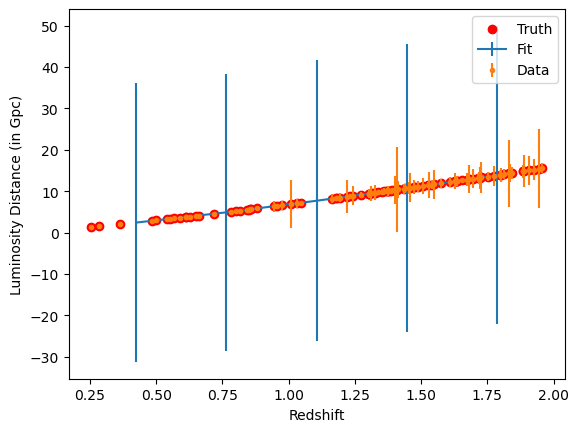

In [86]:
plt.errorbar(zb, DLb_med, yerr=DLb_sd, label="Fit")
plt.errorbar(zo, do, yerr=sigma_DL, fmt='.', label="Data")
plt.scatter(zo, cp.luminosity_distance(zo).to(u.Gpc).value, color='red', label="Truth")
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance (in Gpc)")